In [1]:
from climada.hazard import TCTracks, TropCyclone, Centroids

tracks_sync_1000yr = TCTracks.from_simulations_storm('clim_syn_tracks/STORM_DATA_HadGEM3-GC31-HM_NI_1000_YEARS_0_IBTRACSDELTA.txt')

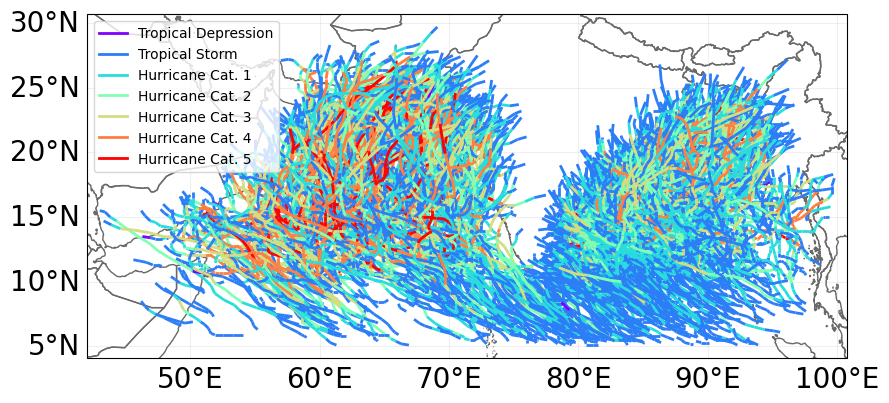

In [2]:
ax = tracks_sync_1000yr.plot()
ax.get_legend()._loc = 2

In [3]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'exposures_coal.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
crs: EPSG:4326
data: (95 entries)
           value  impf_TC                         Plant name  \
0   1.603000e+09        1          Adani Godda power station   
1   1.890239e+09        1     Aditya Aluminium power station   
2   3.784000e+07        1     Amravati Thermal Power Project   
3   4.742700e+08        1                Angul power station   
91  8.483000e+07        1  Visakhapatnam Sarda power station   
92  8.920050e+08        1          Vizag Thermal Power Plant   
93  2.812695e+09        1              Yadadri power station   
94  2.600000e+08        1             Yermarus power station   

                     geometry  
0   POINT (87.13546 24.81411)  
1   POINT (84.06059 21.74007)  
2   POINT (77.90124 21.08032)  
3   POINT (84.98055 21.12704)  
91  POINT (82.96136 17.46644)  
92  POINT (83.13888 17.56364)  
93  POINT (79.58118 16.70822)  
94  POINT (77.35612 16.29526)  


In [4]:
# Define the centroids from the exposures position
lat = exposures["latitude"].values
lon = exposures["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

C:\Users\beste\AppData\Local\Temp\ipykernel_42264\386028382.py:4: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


In [5]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs)

In [6]:
tc.category

array([1, 3, 2, ..., 4, 2, 3])

In [7]:
tc.set_frequency(yearrange=(1980, 2024))
tc.frequency

array([0.02222222, 0.02222222, 0.02222222, ..., 0.02222222, 0.02222222,
       0.02222222])

In [8]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [9]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [10]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

In [11]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 837091946.0 $


<GeoAxes: title={'center': 'Expected annual impact'}>

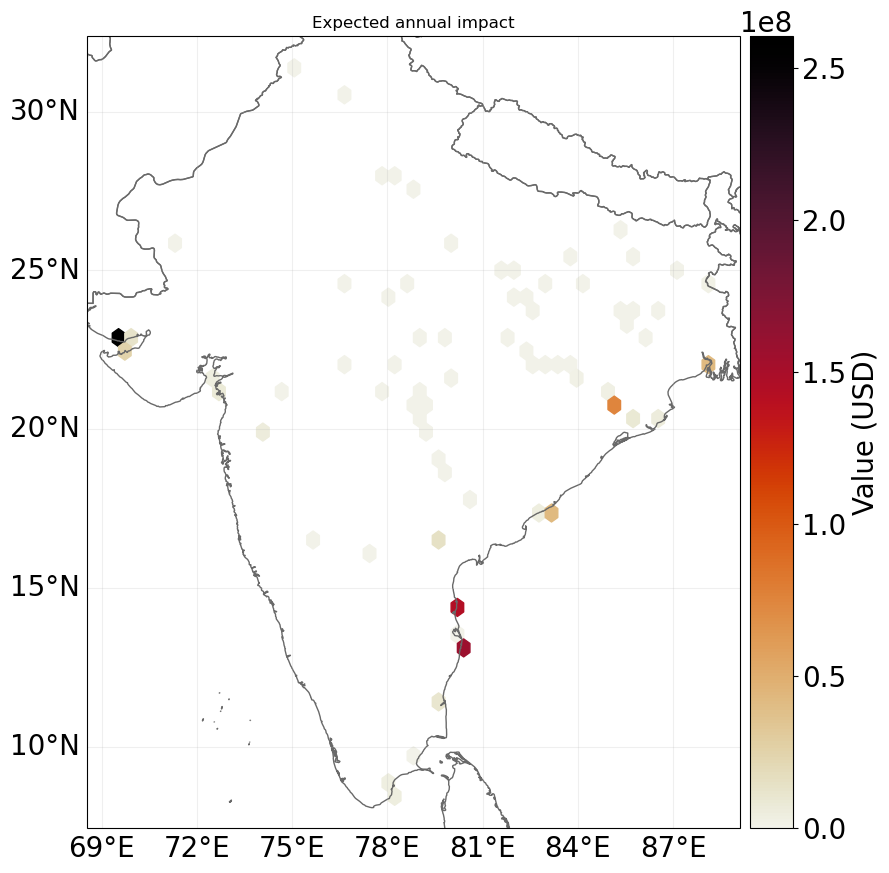

In [12]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False)

In [13]:
imp.impact_per_year()
imp.eai_exp

array([1.51180226e+04, 1.07200821e+06, 0.00000000e+00, 3.02197525e+06,
       6.00567530e+06, 0.00000000e+00, 2.47457407e+07, 6.70330799e+07,
       0.00000000e+00, 5.47534822e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.26099847e+07, 0.00000000e+00, 5.71713475e+03,
       1.68474023e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.35866536e+06, 3.44383847e+05, 0.00000000e+00,
       0.00000000e+00, 4.83169990e+07, 4.25422244e+07, 4.51257849e+06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.99879022e+02,
       2.06580974e+07, 0.00000000e+00, 7.22633527e+06, 2.11899115e+07,
       7.72932099e+05, 0.00000000e+00, 0.00000000e+00, 1.81965650e+05,
       1.43899205e+05, 1.62694969e+05, 2.32122387e+07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.67035003e+05, 0.00000000e+00,
       8.90653711e+04, 0.00000000e+00, 1.07283376e+04, 0.00000000e+00,
       0.00000000e+00, 3.91459934e+06, 0.00000000e+00, 7.91353554e+05,
      

In [14]:
def impact_visual(data):

    tc = TropCyclone.from_tracks(data, centroids=centrs)
    impf_tc = ImpfTropCyclone.from_emanuel_usa()
    # add the impact function to an Impact function set
    impf_set = ImpactFuncSet([impf_tc])
    [haz_type] = impf_set.get_hazard_types()
    [haz_id] = impf_set.get_ids()[haz_type]
    imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True)
    print(f"Aggregated average annual impact: {imp.aai_agg} $")

    return

<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

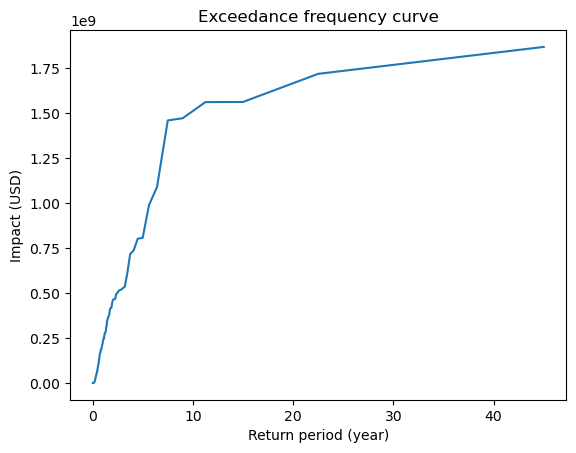

In [15]:
pl = imp.calc_freq_curve()
pl.plot()

In [16]:
imp.at_event

array([2.14292057e+07, 0.00000000e+00, 3.13112458e+06, ...,
       1.12692742e+08, 0.00000000e+00, 0.00000000e+00])

In [17]:
years = [int(tr.attrs['id_no'] / 1000) for tr in tracks_sync_1000yr.data]
years = list(set(years))
years.sort()
print(years)

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 62, 63, 64, 65, 67, 68, 69, 70, 71, 73, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 91, 93, 94, 97, 98, 99, 101, 102, 103, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 180, 181, 183, 185, 186, 187, 189, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 217, 218, 220, 221, 222, 224, 225, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 244, 245, 246, 247, 248, 249, 250, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 2

In [18]:
help(TCTracks.from_simulations_storm)

Help on method from_simulations_storm in module climada.hazard.tc_tracks:

from_simulations_storm(path, years=None) class method of climada.hazard.tc_tracks.TCTracks
    Create new TCTracks object from STORM simulations
    
        Bloemendaal et al. (2020): Generation of a global synthetic tropical cyclone hazard
        dataset using STORM. Scientific Data 7(1): 40.
    
    Track data available for download from
    
        https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d
    
    Wind speeds are converted to 1-minute sustained winds through division by 0.88 (this value
    is taken from Bloemendaal et al. (2020), cited above).
    
    Parameters
    ----------
    path : str
        Full path to a txt-file as contained in the `data.zip` archive from the official source
        linked above.
    years : list of int, optional
        If given, only read the specified "years" from the txt-File. Note that a "year" refers
        to one ensemble of tracks in the data

In [ ]:
from climada.hazard import TCTracks, TropCyclone

i = 1
while i < 100:
    if i == 20:
        break
    print(i)
    tr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=i)
    impact_visual(tr)
    i += 1

1
Aggregated average annual impact: 432063857.6439129 $
2
Aggregated average annual impact: 650346.082013212 $
3
Aggregated average annual impact: 0.0 $
4
Aggregated average annual impact: 5022412.94909648 $
5
Aggregated average annual impact: 54394535.710542195 $
6
Aggregated average annual impact: 0.0 $
7
Aggregated average annual impact: 750596949.461366 $
8
Aggregated average annual impact: 0.0 $
9
Aggregated average annual impact: 1636451.3874413997 $
10
Aggregated average annual impact: 0.0 $
11
Aggregated average annual impact: 0.0 $
12
Aggregated average annual impact: 335910668.5646895 $
13
Aggregated average annual impact: 0.0 $
14
Aggregated average annual impact: 0.0 $
15
Aggregated average annual impact: 0.0 $
16
Aggregated average annual impact: 248077.9020103169 $
17
Aggregated average annual impact: 524251.9365453735 $
18
Aggregated average annual impact: 0.0 $
19
Aggregated average annual impact: 16352555.64322495 $


Aggregated average annual impact: 432063857.6439129 $


<GeoAxes: >

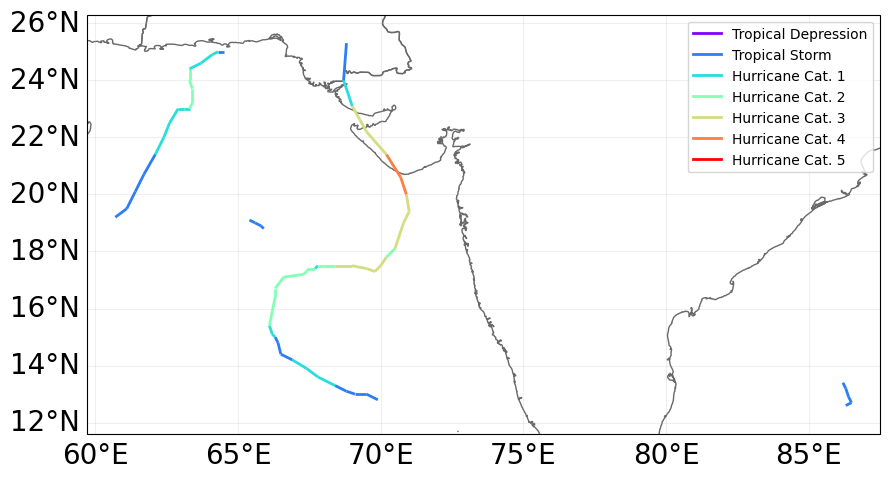

In [20]:
tracks_sync_yr = TCTracks.from_simulations_storm('syn_tracks/STORM_DATA_IBTRACS_NI_1000_YEARS_0.txt',years=1)
impact_visual(tracks_sync_yr)
tracks_sync_yr.plot()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def impact_calculator(return_period, exp, centrs):
    try:
        # Generate a list of years up to the return period
        years = list(range(return_period + 1))

        # Load tropical cyclone tracks
        data = TCTracks.from_simulations_storm('clim_syn_tracks/STORM_DATA_HadGEM3-GC31-HM_NI_1000_YEARS_0_IBTRACSDELTA.txt', years=years)

        # Create a TropCyclone object
        tc = TropCyclone.from_tracks(data, centroids=centrs)

        # Define impact function set
        impf_tc = ImpfTropCyclone.from_emanuel_usa(v_half=70.8)
        impf_set = ImpactFuncSet([impf_tc])

        # Calculate impact
        imp = ImpactCalc(exp, impf_set, tc).impact(save_mat=True)

        return imp.eai_exp  # Return the expected annual impact

    except Exception as e:
        print(f"Error in return period {return_period}: {e}")
        return None

In [30]:
return_periods=[5,10,25,50,100,200,500,1000]

In [31]:
# Calculate impacts
impact_results_coal = {
    rp: impact_calculator(rp, exp, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_coal_df = pd.DataFrame(impact_results_coal)

# Show results
print(damage_coal_df)
damage_coal_df.to_excel('damage_coal.xlsx', index=False)

            5             10            25            50            100   \
0   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  6.550346e+06   
2   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3   0.000000e+00  0.000000e+00  0.000000e+00  2.283372e+06  3.327495e+07   
4   0.000000e+00  0.000000e+00  0.000000e+00  1.532257e+07  1.205374e+08   
..           ...           ...           ...           ...           ...   
90  3.592540e+06  4.475515e+06  4.501780e+06  4.501780e+06  1.666759e+07   
91  0.000000e+00  3.143475e+06  2.875923e+07  2.875923e+07  3.141483e+07   
92  0.000000e+00  1.875089e+07  2.835063e+08  2.835063e+08  3.153426e+08   
93  0.000000e+00  4.454218e+07  4.454218e+07  4.454218e+07  4.857544e+07   
94  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            200           500           1000  
0   8.723349e+05  8.723349e+05  8.723349

PermissionError: [Errno 13] Permission denied: 'damage_coal.xlsx'

Now considering different energy types.

In [ ]:
exp_bio  = Exposures(pd.read_excel('exposure_bioenergy.xlsx'), ref_year=2024)

In [ ]:
# Calculate impacts
impact_results_bio = {
    rp: impact_calculator(rp, exp_bio, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_bio_df = pd.DataFrame(impact_results_bio)

# Show results
print(damage_bio_df)


2025-05-07 14:46:48,768 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:46:49,812 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:46:51,346 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:46:53,435 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:46:56,919 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:47:03,107 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:47:19,239 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 13 coordinates.
2025-05-07 14:48:00,382 - climada.util.coordinates - WARNING -

In [ ]:
damage_bio_df.to_excel('damage_bio.xlsx', index=False)

In [ ]:
exp_oilgas  = Exposures(pd.read_excel('exposure_oil&gas.xlsx'), ref_year=2024)

In [ ]:
# Calculate impacts
impact_results_oilgas = {
    rp: impact_calculator(rp, exp_oilgas, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_oilgas_df = pd.DataFrame(impact_results_oilgas)

# Show results
print(damage_oilgas_df)

2025-05-03 12:09:30,821 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:09:32,284 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:09:34,028 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:09:36,186 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:09:39,927 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:09:46,459 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:10:01,759 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.
2025-05-03 12:10:31,610 - climada.util.coordinates - WARNING -

In [ ]:
damage_oilgas_df.to_excel('damage_oilgas.xlsx', index=False)

In [ ]:
exp_nuclear  = Exposures(pd.read_excel('exposure_nuclear.xlsx'), ref_year=2024)

In [ ]:
# Calculate impacts
impact_results_nuclear = {
    rp: impact_calculator(rp, exp_nuclear, centrs) for rp in return_periods
}

# Convert to DataFrame
damage_nuclear_df = pd.DataFrame(impact_results_nuclear)

# Show results
print(damage_nuclear_df)

2025-05-03 12:11:06,882 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:08,303 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:09,981 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:12,431 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:16,126 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:22,803 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:11:38,568 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.
2025-05-03 12:12:09,461 - climada.util.coordinates - WARNING - Distan

In [ ]:
damage_nuclear_df.to_excel('damage_nuclear.xlsx', index=False)

In [ ]:
exp.gdf.index

RangeIndex(start=0, stop=95, step=1)